In [22]:
import pandas as pd
import numpy as np
import lime
import sklearn
import sklearn.ensemble
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from tqdm import tqdm
import joblib

import warnings
warnings.filterwarnings('ignore')

## Fetching data, training a classifier

For this tutorial, we'll be using the [20 newsgroups dataset](http://scikit-learn.org/stable/datasets/#the-20-newsgroups-text-dataset). In particular, for simplicity, we'll use a 2-class subset: atheism and christianity.

In [23]:
categories = [0, 1]
train = pd.read_csv("data/train_text_and_objects.csv", keep_default_na=False)
test = pd.read_csv("data/test_text_and_objects.csv", keep_default_na=False)
class_names = ['Not Harmful', 'Harmful']

Let's use the tfidf vectorizer, commonly used for text.

In [24]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(train["text_and_objects"])
test_vectors = vectorizer.transform(test["text_and_objects"])

Now, let's say we want to use random forests for classification. It's usually hard to understand what random forests are doing, especially with many trees.

In [25]:
rf = sklearn.ensemble.RandomForestClassifier(
    n_estimators=500,     # Number of trees in the forest.
    max_depth=30,         # Maximum depth of the trees.
    max_features="sqrt",
    min_samples_split=5,  # Minimum number of samples required to split an internal node.
    min_samples_leaf=1,   # Minimum number of samples required to be at a leaf node.
    bootstrap=True,       # Use bootstrap samples when building trees.
    oob_score=True,       # Use out-of-bag samples to estimate the generalization accuracy.
    n_jobs=-1,            # Use all cores available.
    random_state=42,      # Random seed.
    class_weight="balanced" # Use balanced class weights to adjust for imbalanced dataset.
)
rf.fit(train_vectors, train["binary_labels"])

RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_split=5, n_estimators=500, n_jobs=-1,
                       oob_score=True, random_state=42)

In [26]:
pred = rf.predict(test_vectors)
print(f' Accuracy {sklearn.metrics.accuracy_score(test["binary_labels"], pred)}')
print(f' Precision {sklearn.metrics.precision_score(test["binary_labels"], pred, average="binary")}')
print(f' Recall {sklearn.metrics.recall_score(test["binary_labels"], pred, average="binary")}')
print(f' F1-Score {sklearn.metrics.f1_score(test["binary_labels"], pred, average="binary")}')

 Accuracy 0.788135593220339
 Precision 0.6601307189542484
 Recall 0.8145161290322581
 F1-Score 0.7292418772563177


## Explaining predictions using lime

Lime explainers assume that classifiers act on raw text, but sklearn classifiers act on vectorized representation of texts. For this purpose, we use sklearn's pipeline, and implement ````predict_proba```` on raw_text lists.

In [27]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

In [28]:
print(c.predict_proba([test["text_and_objects"][0]]))

[[0.53060366 0.46939634]]


Now we create an explainer object. We pass the ````class_names```` as an argument for prettier display.

In [29]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

We then generate an explanation with at most 6 features for an arbitrary document in the test set.

In [30]:
idx = 83
exp = explainer.explain_instance(test["text_and_objects"][idx], c.predict_proba, num_features=10)
print('Document id: %d' % idx)
print('Probability(Harmful) =', c.predict_proba([test["text_and_objects"][idx]])[0, 1])
print('True class: %s' % class_names[test["binary_labels"][idx]])

Document id: 83
Probability(Harmful) = 0.5902344201778397
True class: Harmful


In [31]:
df_pred = []
for idx in range(0,len(test)):
    exp = explainer.explain_instance(test["text_and_objects"][idx], c.predict_proba, num_features=2)
    print('Document id: %d' % idx)
    dict_pred = {
        "id": idx,
        "Prob (Harmful)": c.predict_proba([test["text_and_objects"][idx]])[0, 1],
        "True Class": class_names[test["binary_labels"][idx]],
        "Explainers":exp.as_list()
    }
    
    df_pred.append(dict_pred)

Document id: 0
Document id: 1
Document id: 2
Document id: 3
Document id: 4
Document id: 5
Document id: 6
Document id: 7
Document id: 8
Document id: 9
Document id: 10
Document id: 11
Document id: 12
Document id: 13
Document id: 14
Document id: 15
Document id: 16
Document id: 17
Document id: 18
Document id: 19
Document id: 20
Document id: 21
Document id: 22
Document id: 23
Document id: 24
Document id: 25
Document id: 26
Document id: 27
Document id: 28
Document id: 29
Document id: 30
Document id: 31
Document id: 32
Document id: 33
Document id: 34
Document id: 35
Document id: 36
Document id: 37
Document id: 38
Document id: 39
Document id: 40
Document id: 41
Document id: 42
Document id: 43
Document id: 44
Document id: 45
Document id: 46
Document id: 47
Document id: 48
Document id: 49
Document id: 50
Document id: 51
Document id: 52
Document id: 53
Document id: 54
Document id: 55
Document id: 56
Document id: 57
Document id: 58
Document id: 59
Document id: 60
Document id: 61
Document id: 62
Do

In [32]:
df_pred = pd.DataFrame(df_pred)
df_pred["Prob Class"] = np.where(df_pred["Prob (Harmful)"]>=0.5,"Harmful","Not Harmful")
df_pred

,id,Prob (Harmful),True Class,Explainers,Prob Class
0,0,0.469396,Not Harmful,"[(trump, 0.1169529502502709), (2020, -0.070386...",Not Harmful
1,1,0.590845,Not Harmful,"[(trump, 0.15296144353417013), (biden, 0.07485...",Harmful
2,2,0.660960,Not Harmful,"[(trump, 0.16356755419783037), (tie, 0.0670559...",Harmful
3,3,0.683989,Not Harmful,"[(trump, 0.1693199734990199), (tie, 0.07413646...",Harmful
4,4,0.743884,Not Harmful,"[(trump, 0.1438243517955391), (china, 0.090579...",Harmful
...,...,...,...,...,...
349,349,0.320137,Not Harmful,"[(day, -0.0900714999179774), (person, 0.044032...",Not Harmful
350,350,0.516853,Not Harmful,"[(say, 0.06906346401770386), (person, 0.044963...",Harmful
351,351,0.333345,Not Harmful,"[(day, -0.08714002530779635), (person, 0.03286...",Not Harmful
352,352,0.374979,Not Harmful,"[(meme, -0.07183836191348332), (person, 0.0375...",Not Harmful


In [33]:
explainer_list=[]
c=0
for i in df_pred["Explainers"]:
    for k in i:
        explainer_dict={
            "id": c,
            "word":k[0],
            "value":k[1]
        }
        explainer_list.append(explainer_dict)
    c+=1
        
        
explainer_list=pd.DataFrame(explainer_list)
explainer_list = explainer_list.merge(df_pred, on="id")
explainer_list

,id,word,value,Prob (Harmful),True Class,Explainers,Prob Class
0,0,trump,0.116953,0.469396,Not Harmful,"[(trump, 0.1169529502502709), (2020, -0.070386...",Not Harmful
1,0,2020,-0.070387,0.469396,Not Harmful,"[(trump, 0.1169529502502709), (2020, -0.070386...",Not Harmful
2,1,trump,0.152961,0.590845,Not Harmful,"[(trump, 0.15296144353417013), (biden, 0.07485...",Harmful
3,1,biden,0.074857,0.590845,Not Harmful,"[(trump, 0.15296144353417013), (biden, 0.07485...",Harmful
4,2,trump,0.163568,0.660960,Not Harmful,"[(trump, 0.16356755419783037), (tie, 0.0670559...",Harmful
...,...,...,...,...,...,...,...
703,351,person,0.032861,0.333345,Not Harmful,"[(day, -0.08714002530779635), (person, 0.03286...",Not Harmful
704,352,meme,-0.071838,0.374979,Not Harmful,"[(meme, -0.07183836191348332), (person, 0.0375...",Not Harmful
705,352,person,0.037536,0.374979,Not Harmful,"[(meme, -0.07183836191348332), (person, 0.0375...",Not Harmful
706,353,quarantine,-0.064363,0.328495,Not Harmful,"[(quarantine, -0.06436318137262395), (vaccine,...",Not Harmful


In [34]:
harmful_count = explainer_list.groupby(['word', 'Prob Class']).size().reset_index(name='count')
harmful_count = harmful_count.pivot_table(index='word', columns='Prob Class', values='count', fill_value=0)
harmful_count.columns = ['Not Harmful', 'Harmful']
harmful_count.reset_index(inplace=True)

harmful_count["count"] = harmful_count["Not Harmful"]+harmful_count["Harmful"]
harmful_count=harmful_count.sort_values(by="count", ascending=False).head(10)
#harmful_count = harmful_count.pivot_table(index='word', values=['Not Harmful', 'Harmful'], aggfunc='sum')
harmful_count

,word,Not Harmful,Harmful,count
85,person,52.0,116.0,168.0
115,trump,80.0,4.0,84.0
109,tie,59.0,10.0,69.0
120,virus,22.0,9.0,31.0
91,quarantine,0.0,19.0,19.0
5,2020,2.0,16.0,18.0
37,dog,0.0,18.0,18.0
38,donald,15.0,1.0,16.0
32,day,0.0,13.0,13.0
80,meme,3.0,10.0,13.0


## Visualizing explanations

In [35]:
harmful_long = pd.melt(harmful_count, id_vars='word', var_name='Result', value_name='Count')
harmful_long.sort_values(by="word")

,word,Result,Count
25,2020,count,18.0
5,2020,Not Harmful,2.0
15,2020,Harmful,16.0
8,day,Not Harmful,0.0
18,day,Harmful,13.0
28,day,count,13.0
26,dog,count,18.0
6,dog,Not Harmful,0.0
16,dog,Harmful,18.0
27,donald,count,16.0


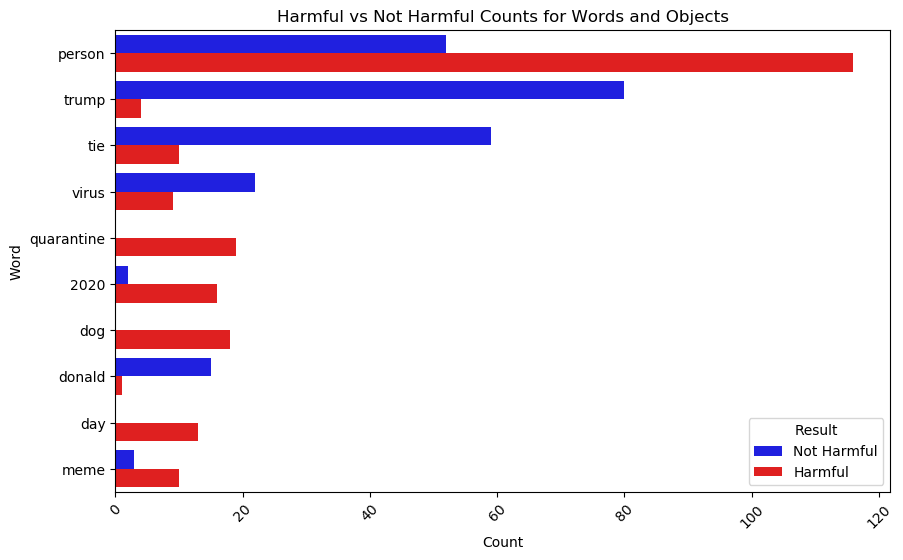

In [36]:
# Correcting the code snippet provided by the user and plotting the barplot accordingly
# First, we'll need to convert the DataFrame from wide to long format

# For the given data, we can use 'pd.melt' instead of 'pd.wide_to_long' for simplici
# Now, let's create the barplot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(y='word', x='Count', hue='Result', data=harmful_long[harmful_long["Result"]!="count"], palette=['blue', 'red'])

# Adding legend and labels
plt.legend(title='Result')
plt.ylabel('Word')
plt.xlabel('Count')
plt.title('Harmful vs Not Harmful Counts for Words and Objects')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

# Display the plot
plt.savefig("plots/RF/3.Top10HarmfulHarmlessWordAndObjectsCount.jpeg")


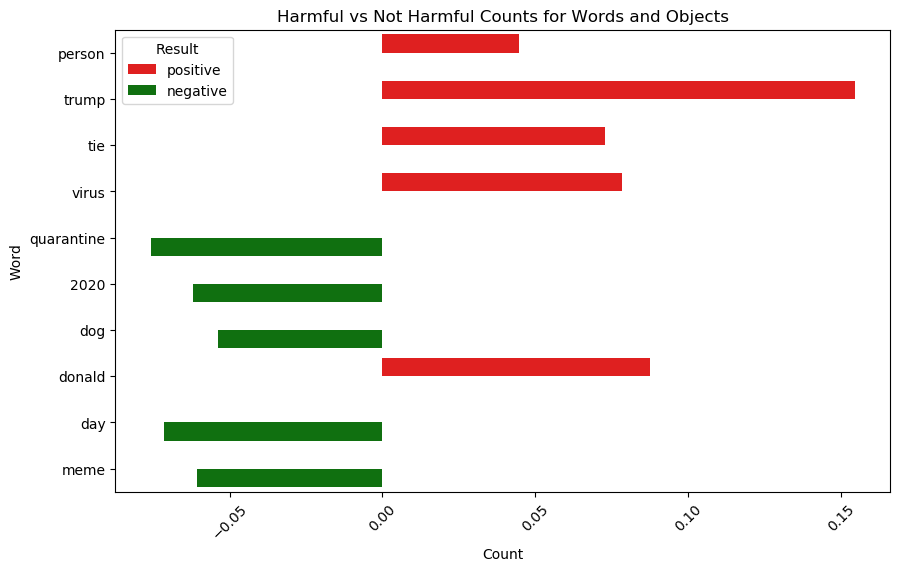

In [37]:
exp_val =explainer_list[["word","value"]].groupby("word").mean("value")
exp_val["dir"] = np.where(exp_val["value"]>=0,"positive","negative")

top10=harmful_long[harmful_long["Result"]!="count"][["word"]].drop_duplicates()

top10 = top10.merge(exp_val, how="inner",on="word")


plt.figure(figsize=(10, 6))
sns.barplot(y='word', x='value',hue="dir" , data=top10, palette=["red","green"])

# Adding legend and labels
plt.legend(title='Result')
plt.ylabel('Word')
plt.xlabel('Count')
plt.title('Harmful vs Not Harmful Counts for Words and Objects')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

# Display the plot
plt.savefig("plots/RF/3.Top10HarmfulHarmlessWordAndObjectsValues.jpeg")


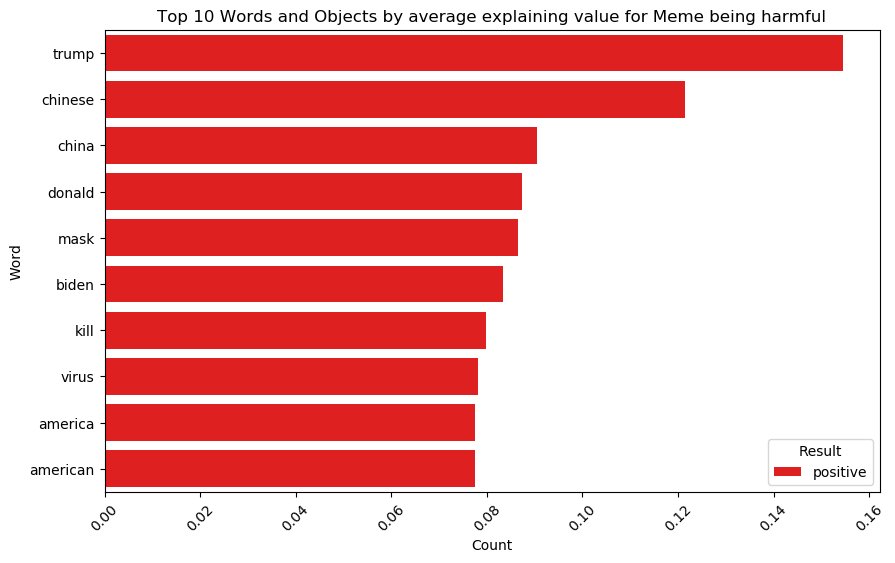

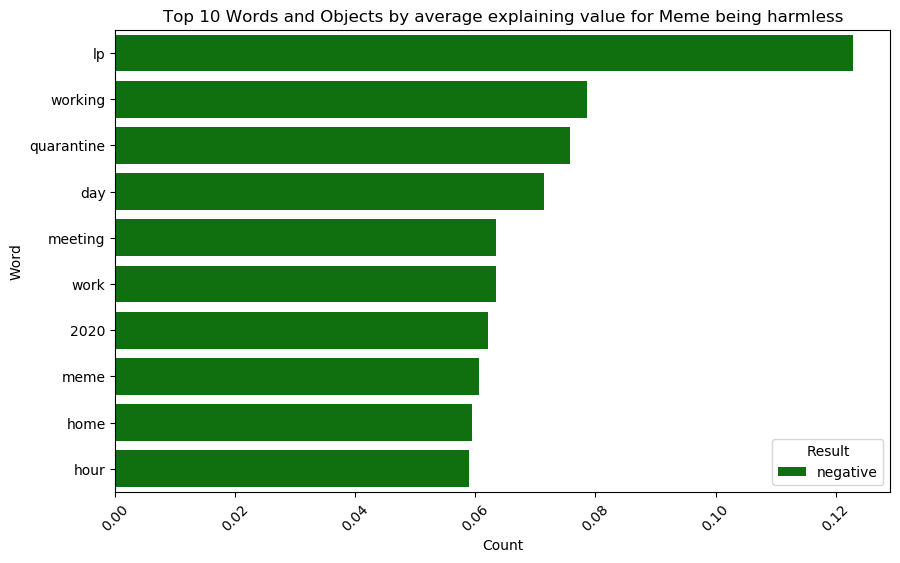

In [38]:
exp_p = exp_val[exp_val["dir"]=="positive"].sort_values("value",ascending=False).head(10)
exp_n = exp_val[exp_val["dir"]=="negative"].sort_values("value",ascending=True).head(10)
exp_n["value"]=exp_n["value"]*-1

plt.figure(figsize=(10, 6))
sns.barplot(y=exp_p.index, x='value',hue="dir" , data=exp_p, palette=["red"])

# Adding legend and labels
plt.legend(title='Result')
plt.ylabel('Word')
plt.xlabel('Count')
plt.title('Top 10 Words and Objects by average explaining value for Meme being harmful')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

# Display the plot
plt.savefig("plots/RF/3.Positive_Top10WordsAndObjectsByValues.jpeg")

plt.figure(figsize=(10, 6))
sns.barplot(y=exp_n.index, x='value',hue="dir" , data=exp_n, palette=["green"])

# Adding legend and labels
plt.legend(title='Result')
plt.ylabel('Word')
plt.xlabel('Count')
plt.title('Top 10 Words and Objects by average explaining value for Meme being harmless')
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability

# Display the plot
plt.savefig("plots/RF/3.Negative_Top10WordsAndObjectsByValues.jpeg")
